# How people hashtagging
### During election 2020

> A hack on [election tweets dataset](https://www.kaggle.com/manchunhui/us-election-2020-tweets), please upvote the dataset for his dedicated effort to collect the data

![data image](https://storage.googleapis.com/kaggle-datasets-images/935914/1582537/4fc3f5fa3b371aad3c097e7fb892305b/dataset-cover.jpg?t=2020-10-23-13-26-22)

The election is at some extent all over, but what worries me is the ever so separated perception of media, stories, even the basic definition of things that leads to a devided society.  As the problem described so vividly by the Netflix documentary [The Social Delimma](https://www.imdb.com/title/tt11464826/). 

This notebook tries to look closely at the diversity forms of tweet texts and how online society devides. And I hope the data science community can move toward the goal of bringing down segregation/news integrity in one day

In [1]:
!pip install -q forgebox

In [2]:
from forgebox.imports import *
from forgebox.df import PandasDisplay

from datetime import datetime
from typing import List, Tuple
import random

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from wordcloud import WordCloud
from forgebox.html import DOM
from forgebox.images.widgets import image_dom
from itertools import chain

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/us-election-2020-tweets/hashtag_joebiden.csv
/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv


All the tweets are either hash tagging D.J.Trump or J.R.Biden， saved separately in 2 csv files

In [3]:
DATA = Path("/kaggle/input/us-election-2020-tweets/")

trump_df = pd.read_csv(
    DATA/"hashtag_donaldtrump.csv",
    lineterminator='\n', error_bad_lines=False)
biden_df = pd.read_csv(DATA/"hashtag_joebiden.csv", error_bad_lines=False)
# Remove the error lines (last column nan)
trump_df = trump_df[~trump_df.collected_at.isna()]
biden_df = biden_df[~biden_df.collected_at.isna()]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Remove the error lines (last column nan)

In [4]:
trump_df.columns

Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at'],
      dtype='object')

In [5]:
us_countries = ['United States of America','United States']

def compare_vc(col, filter_query="tweet_id!=''"):
    """
    Compare value counts of 2 candidate
    """
    DOM(f"Value counts under 2 candidates on column {col.upper()}", "h3")()
    return biden_df.query(filter_query).vc(col).rename(columns={col: "biden"}).join(
        trump_df.query(filter_query).vc(col).rename(columns={col: "trump"})
    ).head(20)

In [6]:
compare_vc("country")

biden     trump
United States of America  153595  178899.0
United States              27541   34364.0
United Kingdom             23307   34743.0
India                      21530   18559.0
France                     14609   20689.0
Germany                    12761   22618.0
Canada                     10809   16996.0
Italy                       8869   11206.0
Australia                   5534    9365.0
Mexico                      5089    5811.0
Turkey                      4774    5594.0
Pakistan                    4366    4231.0
Brazil                      4160    4575.0
The Netherlands             3981    5606.0
Spain                       2962    4290.0
Ireland                     2641    2811.0
Netherlands                 2280    2999.0
Argentina                   2081    2323.0
Colombia                    2070    2355.0
Venezuela                   1739    2594.0

In [7]:
compare_vc("state",f"(country in {us_countries})")

biden    trump
California            25816  31149.0
New York              21005  22881.0
Texas                 14191  16491.0
Florida               13278  16559.0
District of Columbia   7055   9684.0
Illinois               5500   6777.0
Pennsylvania           5403   7011.0
Ohio                   4413   3871.0
New Jersey             3961   5045.0
Massachusetts          3738   4719.0
Arizona                3248   2865.0
Georgia                3186   2876.0
Michigan               3074   3053.0
North Carolina         3054   3415.0
Colorado               2687   3618.0
Oregon                 2250   3126.0
Nevada                 2233   2388.0
Virginia               2226   2489.0
Washington             2112   2759.0
Maryland               2069   2189.0

In [8]:
compare_vc("source")

biden     trump
Twitter for iPhone              244804  274034.0
Twitter Web App                 240240  321067.0
Twitter for Android             218908  269275.0
Twitter for iPad                 26029   35333.0
TweetDeck                        12504   17484.0
Instagram                         5997    5506.0
Hootsuite Inc.                    3925    5401.0
Buffer                            1904    2914.0
Twitter Media Studio              1383    1466.0
WordPress.com                     1087    1537.0
dlvr.it                            854    1686.0
IFTTT                              714    1879.0
Tweetbot for iΟS                   603    1174.0
TweetCaster for Android            539    1194.0
SocialFlow                         500     690.0
Echobox                            491     599.0
Twitter for Mac                    467     654.0
Periscope                          446     763.0
Twitter Media Studio - LiveCut     427     479.0
Blog2Social APP                    424     580.0

But to be honest, the hashtag distribution among countries, states etc demonstrate nothing meaning full, we still don't know what kind of information is pro-trump, what is anti-trump

## Combine the tweet data into one

In [9]:
all_df = pd.concat([trump_df, biden_df])

all_df = all_df.query("retweet_count>2").reset_index(drop=True)

def replace_us(x): return "US" if x in us_countries else x

all_df["country"]= all_df["country"].apply(replace_us)

## Find the hash_tag(#) and the at(@)

With regex ```r"@(\w+)"``` for @ and ```r"#(\w+)"``` for hash tag

In [10]:
%%time
import re

def find_at(text):
    return re.findall(r"@(\w+)",text)

def find_hashtag(text):
    return re.findall(r"#(\w+)",text)

all_df["at_s"] = all_df.tweet.apply(find_at)
all_df["hash_tags"] = all_df.tweet.apply(find_hashtag)

CPU times: user 1.09 s, sys: 30.3 ms, total: 1.12 s
Wall time: 1.12 s


## Frequent Hash Tag

In [11]:
p_display=PandasDisplay(max_colwidth = 0,max_rows=120)

Here are the top mentioned hashtags 

In [12]:
all_hashtags = chain(*all_df["hash_tags"])
hashtag_stat = pd.DataFrame({"hashtag":all_hashtags}).vc("hashtag")
with p_display:
    display(hashtag_stat.head(100))

hashtag
Trump                        63872  
Biden                        45027  
JoeBiden                     22558  
Election2020                 12005  
DonaldTrump                  10982  
Elections2020                8735   
trump                        5498   
ElectionDay                  5118   
Trump2020                    3656   
USA                          3489   
BidenHarris2020              3180   
biden                        3002   
ElectionNight                2978   
USElection2020               2912   
Elecciones2020               2761   
COVID19                      2269   
KamalaHarris                 2268   
ElectionResults2020          2122   
USAElections2020             2107   
MAGA                         2018   
TRUMP                        1939   
USElections2020              1904   
EEUU                         1511   
Pennsylvania                 1497   
Debates2020                  1482   
Michigan                     1382   
Biden2020                    1379   
VOTE                         1356   
TrumpvsBiden                 1319   
HunterBiden                  1309   
USElection                   1309   
BidenHarris                  1259   
Election2020results          1203   
Vote                         1167   
elections                    1160   
America                      1160   
USAelection2020              1138   
Georgia                      1129   
joebiden                     1058   
bidenharis2020               1046   
vote                         1018   
TrumpMeltdown                986    
US                           975    
Obama                        940    
Arizona                      926    
Wisconsin                    922    
China                        886    
USElections                  871    
Nevada                       852    
EtatsUnis                    829    
coronavirus                  826    
USElectionResults2020        820    
Vote2020                     812    
Florida                      804    
MAGA2020                     794    
Elecciones                   768    
BIDEN                        736    
Democrats                    729    
election                     691    
election2020                 678    
2020Election                 674    
ByeByeTrump                  666    
donaldtrump                  633    
EstadosUnidos                633    
TrumpIsLosing                627    
Resist                       617    
USPresidentialElections2020  616    
Twitter                      603    
USElectionResults            602    
GOP                          598    
USA2020                      579    
Harris                       573    
CNN                          572    
ElectionDay2020              553    
Texas                        553    
JoeBidenKamalaHarris2020     543    
BREAKING                     543    
PresidentialDebate2020       537    
AmericaDecides2020           502    
USWahlen2020                 493    
usa                          487    
VoteEarly                    485    
JOEBIDEN2020                 473    
POTUS                        465    
WhiteHouse                   464    
FoxNews                      459    
COVID                        438    
EleccionesEEUU               437    
VoteHimOut                   435    
Debate2020                   424    
politics                     419    
DebateTonight                415    
PresidentElectJoe            405    
KAG                          397    
BLM                          396    
eleccion2020                 390    
Usa2020                      387    
Republicans                  387    
Cuba                         382    
Truth                        382

# Manual review
> I mannually review 12 tweets sampled from each hashtag, of the top frequent hashtags. And put the hashtag into "Pro Trump" or "Pro Biden" list to the best of my judgement.(eg if some hashtag looks like pro-trump, but the sample tweets hashtagged this phrase isn't always pro trump, I won't label it pro trump)

> To be clear I'm a coder/ Chinese citizen who's hooked to the US 2020 election rallies news/ tweets/ posts/ conspiracy theory non-stop, all of those from both sides, so my judgement might not be very accurate, besides, there are lots of non-english expression. I seriously hoped someone can try and relabel that

In [13]:
def start_review(hashtag_stat):
    gen = iter(hashtag_stat.index)
    def next_ht():
        """
        Review hashtags one by one
        """
        ht = next(gen)
        DOM(f"#{ht}","h3")()
        has_ht = all_df["hash_tags"].apply(lambda x: ht in x)
        total = has_ht.sum()
        DOM(f"Total count: {total}, {int(total*100/len(all_df))}%","h4")()
        frame = DOM("","div",{"class":"row"})
        for tweet in all_df[has_ht].sample(12).tweet:
            frame.append(DOM(tweet.replace(ht, f"<span class='text-danger'>{ht}</span>"),
                             "div",{"class":"col-sm-4"}))
        frame()
    return next_ht

In [14]:
PRO_TRUMP = ["Trump2020","MAGA","HunterBiden", "China", "MAGA2020", "KAG", "Trump2020Landslide", "Trump2020LandslideVictory",
             "TRUMP2020ToSaveAmerica","maga", "HunterBidenLaptop", "BidenCrimeFamiily", "PresidentTrump",
             "ccp","hunter", "HunterBidenEmails", "4MoreYears","TrumpPence2020"
            ]
PRO_BIDEN = [ "TrumpOut", "TrumpGenocide", "Biden2020", "TrumpMeltdown","BlueWave","BidenHarris2020", "BidenHaris2020",
             "ByeByeTrump", "TrumpIsLosing","Resist", "VoteHimOut", "PresidentElectJoe", "Truth",
             "TrumpVirus","VoteBidenHarris2020", "VoteBlue","CountEveryVote", "BidenPresident",
             "BidenHarrisToSaveAmerica","TrumpOut", "TrumpCrimeFamily", "BidenHarrisLandslide2020",
             "TrumpIsANationalDisgrace","TrumpCollapse","PresidentElect", "ByeByeTrump","VoteBidenHarrisToSaveAmerica",
             "VoteBlueToSaveAmerica", "VoteBiden", "DumpTrump","JoeBiden2020"
            ]

In [15]:
next_ht = start_review(hashtag_stat)

I repeated run next_ht to review the tweet message 😭

In [16]:
next_ht()

## Display some samples

In [17]:
with p_display:
    display(
        all_df[["tweet", "user_name", "retweet_count", "at_s", "hash_tags"]].sample(20))

tweet  \
32569   Congrats boss! .@realDonaldTrump \n#DonaldTrump takes the #Moon in #Election2020                                                                                                                                                                                                                                      
5750    #Trump \n\nLe Pdt Trump accélère et \nprévoie de faire cinq meetings par jour avant les élections.  \n"Nous allons gagner. Je n'étais pas en mesure de vous le dire  il y as trois semaines" admettant que ce n'était pas facile de retourner de l'hôpital à la campagne électorale.\n#MAGA https://t.co/reecVBb15f   
40827   Che perda o vinca, non si può certo dare torto a #Trump che lo chiama Sleepy Joe, lo vedrei bene, per brillantezza, competenza e prontezza di riflessi, come nuovo leader del PD italiano. https://t.co/HtzQFW552b                                                                                                    
31423   La cosa viene GRANDE, #Trump arrasando en Miami Dade County, en la Florida un condado rabiosamente Democrata. #Elecciones2020 #Trump2020 https://t.co/AufAv5pFHq                                                                                                                                                      
13116   Remember #Trump was briefed on #COVID19 in January. He ignored it. Now, hundreds of thousands of Americans are paying the ultimate price for his incompetency. Don’t reward him for killing your neighbor! #vote #VoteHimOut #TrumpLiesAmericansDie                                                                   
56124   Donald #Trump will Wahlergebnis nicht anerkennen. Wie es weitergeht: \n#BidenHarrris2020 https://t.co/sa6awaNjGQ                                                                                                                                                                                                      
45549   🇺🇸 Richard #Grenell: „Joe Gloria, ein Wahlbeamter aus Clark County, sagt, er könne nicht garantieren, dass es in #Nevada keinen Wahlbetrug gibt. Und er gewährt dem #Trump-Team keinen Zugang, um die Überprüfung der Unterschriften zu beobachten. Wir sind besorgt, dass....                                        
56068   Fa 5 anys una assessora de #MarcoRubio, Senador per Florida i llavors candidat a primàries, em va dir: "Si guanya #Trump, farà un mal irreparable a la imatge del #republicanparty". Avui toquen fons. Veurem però què sap fer #biden amb el regal que li ha fet el destí. #Election2020                              
839     #TwitterCensorship to protect #BidenCrimeFamily #Corruption is #ElectionInterference equal to #China or #Cuba actions\n\n#Democrats and #FakeNews have blocked all negative info about #BejingBiden #BurismaBiden to keep #Americans in the dark \n\n#thursdayvibes #Trump @PrideNews1 https://t.co/pB8qvqglr4        
33989   #Elecciones2020 #JoeBiden #DonaldTrump El presidente Donald Trump se acaba de pronunciar en su cuenta de Twitter. Afirma que, "Tenemos una amplia diferencia , pero están tratando de robar las elecciones". https://t.co/8vKIAbTNUr                                                                                  
17290   @kylegriffin1 If the poor don't get their lenders to forgive their loans like #Trump did, the poor don't want to be successful. This is sarcasm folks.i  am thinking like #JaredKushner                                                                                                                               
102700  Joe #Biden: fighter w polityce i życiu prywatnym. Jaki jest zwycięzca wyborów w #USAelection2020 \n\ntxt by @MaciasCzarnecki \n\n https://t.co/10LEWBwtVr                                                                                                                                                             
15261   #USA: un convoi "Jews for #Trump" pris à partie à New York \n►Tous les détails avec @SandyFortis, journaliste #i24NEWS https://t.co/t3bp0TBGbr             

## All ats and hashtags

## Learn the graph

In [18]:
class HashTagGraph(Dataset):
    @classmethod
    def from_df(cls, df: pd.DataFrame):
        # count unique hash tag numbers in a row
        df["ht_count"] =  df.hash_tags.apply(lambda x:len(set(x)))
        # we use the lower case
        df["hash_tags_lower"] = df.hash_tags.apply(lambda x:list(i.lower() for i in x))
        # we use the group with more than 1 hash tag
        hashtag_groups = list(df.query("ht_count>1")["hash_tags_lower"])
        return cls(hashtag_groups)
        
    def __init__(self, hashtag_groups: List[str]):
        self.hashtag_groups = hashtag_groups
        self.all_hashtags = list(chain(*self.hashtag_groups))
        self.hashtag_stat = pd.DataFrame(
            pd.DataFrame({"hashtags": self.all_hashtags})["hashtags"].value_counts()
        )
        self.total_pool = np.arange(len(self.hashtag_stat))
        self.i2c = np.array(self.hashtag_stat.index)
        self.c2i = dict((v,k) for k,v in enumerate(self.hashtag_stat.index))
        
    def __len__(self): return len(self.hashtag_groups)
        
    def __getitem__(self, idx: int) -> Tuple[int]:
        group = self.hashtag_groups[idx]
        choices = random.sample(group, 2 )
        return tuple([
            self.c2i[choices[0]],
            self.c2i[choices[1]],
            random.choice(self.total_pool),
        ])

In [19]:
ds = HashTagGraph.from_df(all_df)
ds[5]

(2726, 0, 17236)

In [20]:
def get_dl(df, batch_size=256, num_workers=4):
    ds = HashTagGraph.from_df(df)
    return DataLoader(
        ds, shuffle=True,
        batch_size=batch_size,
        num_workers=num_workers)

def get_gen(df, **kwargs):
    return iter(get_dl(df, **kwargs))

In [21]:
gen = get_gen(all_df)

for i in range(30):
    x1,x2,z = next(gen)
print(",".join(map(str,map(lambda x:x.shape, [x1, x2, z]))))

torch.Size([256]),torch.Size([256]),torch.Size([256])


## Train a graph

In [22]:
import pytorch_lightning as pl
pl.__version__

'1.0.4'

In [23]:
class GraphData(pl.LightningDataModule):
    def __init__(self, df, batch_size=256):
        super().__init__()
        self.df=df
        self.batch_size=batch_size
        self.ds = HashTagGraph.from_df(self.df)
        self.c2i=ds.c2i
        self.i2c=ds.i2c
        
    def train_dataloader(self):
        return DataLoader(self.ds, shuffle=True, batch_size=self.batch_size, num_workers=4)

In [24]:
graph_data = GraphData(all_df)
num_cates = len(graph_data.i2c)
num_cates

31452

## Loss Function
> Cosine Embedding Loss

$\text{loss}(x, y) =
    \begin{cases}
    1 - \cos(x_1, x_2), & \text{if } y = 1 \\
    \max(0, \cos(x_1, x_2) - \text{margin}), & \text{if } y = -1
    \end{cases}
$

In [25]:
class Graph(pl.LightningModule):
    def __init__(
        self,
        num_cates: int=num_cates,
        margin: float=32.
    ):
        super().__init__()
        self.num_cates = num_cates
        self.emb = nn.Embedding(num_cates, 32)
        self.crit = nn.CosineEmbeddingLoss(margin)
        
    def forward(
        self, x1, x2, z):
        x_1 = torch.cat([x1,x1])
        x_2 = torch.cat([x2,z])
        y = torch.cat([
            torch.ones_like(x2),
            -torch.zeros_like(z),
        ])
        return self.crit(self.emb(x_1), self.emb(x_2), y)
        
    def configure_optimizers(self): return torch.optim.Adam(self.parameters())
        
    def training_step(self, batch, batch_idx):
        x1, x2, z = batch
        loss = self(x1, x2, z)
        return {"loss":loss}
    
graph = Graph()

In [26]:
trainer = pl.Trainer(max_epochs=40)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [27]:
trainer.fit(graph, graph_data)


  | Name | Type                | Params
---------------------------------------------
0 | emb  | Embedding           | 1 M   
1 | crit | CosineEmbeddingLoss | 0     


1

In [28]:
vecs = graph.emb.weight.data.numpy()
vecs.shape

(31452, 32)

## Find closest hashtag

In [29]:
class CosineSim:
    def __init__(self, names: List[str], vecs: np.array, top_k: int=20):
        self.names = np.array(names)
        self.n2i = dict((v,k) for k,v in enumerate(self.names))
        self.top_k = top_k
        self.vecs = vecs
        self.l2 = np.sqrt(np.power(vecs,2).sum(-1))
        self.vecs_normed = vecs/(self.l2[:,None])
        
    def __repr__(self):return f"Cosine Similarity Engine:\n\t"+",".join(self.names[:10])+",..."
    
    def __call__(self, name):
        i = self.n2i.get(name)
        
        if i is None: raise ValueError(f"[ERROR] name '{name}' not found")
        
        sim_map = (self.vecs_normed[i,None]*self.vecs_normed).sum(-1)
        df = pd.DataFrame({"names":self.names,"sim":sim_map}).sort_values(by = "sim", ascending=False)
        return df.head(self.top_k)

In [30]:
CosineSim(graph_data.ds.hashtag_stat.index, vecs)("trump2020")

names       sim
7               trump2020  1.000000
1442         breakingpoll  0.999964
0                   trump  0.999963
240               géorgie  0.999962
6             electionday  0.999956
1                   biden  0.999955
613                 usa20  0.999954
3            election2020  0.999951
5           elections2020  0.999947
44              wisconsin  0.999947
711     burakhocailesecim  0.999946
2                joebiden  0.999945
32    election2020results  0.999945
28           trumpvsbiden  0.999942
953              eudecide  0.999941
17    electionresults2020  0.999939
31                georgia  0.999937
9                    vote  0.999937
8                     usa  0.999935
552   counteverylegalvote  0.999932

In [31]:
top_hashtags = graph_data.ds.hashtag_stat.head(150)
top_ids = np.array(list(graph_data.ds.c2i[i] for i in top_hashtags.index))

tsne=TSNE(2, metric="cosine", )
emb_coords = tsne.fit_transform(graph.emb.weight.data.numpy()[top_ids])

# pca=PCA(2)
# emb_coords = pca.fit_transform(graph.emb.weight.data.numpy()[top_ids])

# Visualize manifold

> We visualize the the TSNE of the top 150 mentioned hashtags, and marked the blue or red for clear preference of such hashtag

> You can see the clustering effect of the graph isn't that impressive 🥶, but some similar words are groupped up together

In [32]:
pro_trump = list(map(lambda x:x.lower(),PRO_TRUMP))
pro_biden = list(map(lambda x:x.lower(),PRO_BIDEN))

color_list =list((
    "1 pro_trump" if i in pro_trump else 
    ("0 pro_biden" if i in pro_biden else
     "2 no_preference")) for i in top_hashtags.index)
fig = px.scatter(
    emb_coords,
    x=0, y=1,
    hover_name=top_hashtags.index,
    color=color_list,
    color_discrete_map={"0 pro_biden":"blue","1 pro_trump":"red" }
)
fig.update_traces(marker_size=8)
fig.show()

## Words Ownership

> Okay let's try words ownership by country, states, some words just appearing a lot, like trump biden, but they are in almost evey tweet, but some words are only owned by certain category of data

In [33]:
hashtags = list(chain(*all_df["hash_tags_lower"]))
hashtag_stat = pd.DataFrame({"hashtags": hashtags}).vc("hashtags")

h2count = dict(zip(hashtag_stat.index, hashtag_stat.hashtags))

In [34]:
def calc_owner(df, col):
    keys = list(df.vc(col).index)[:20]
    result = []
    for k in keys:
        tags = list(chain(*df.query(f"{col}=='{k}'").hash_tags_lower))
        k_df = pd.DataFrame({"ht": tags}).vc("ht").reset_index()
        k_df[f"{col}"] = k
        k_df = k_df.rename(columns={"index": "hashtag", "ht":"ct"})
        result.append(k_df)
    return_df = pd.concat(result)[[col, "hashtag", "ct", ]]
    return_df["total"] = return_df["hashtag"].apply(lambda x:h2count[x])
    return_df["ownership"] = return_df["ct"] / return_df["total"]
    return return_df

def clean_onwership(df, col):
    col_df = calc_owner(df, col)
    rt = []
    wc_painter = WordCloud(
            background_color="white",
            height=500, width=800
            )
    for k in col_df[col].unique():
        k_df = col_df.query(f"{col}=='{k}'").query(f"ct>3")
        k_df = k_df.sort_values(by = ["ownership","total"], ascending=False).reset_index(drop=2).head(50)
        wc = wc_painter.generate(" ".join(k_df.hashtag))
        DOM(f"{col}:{k}", "h3")()
        image_dom(wc.to_image())()

# Word cloud hashtag by country


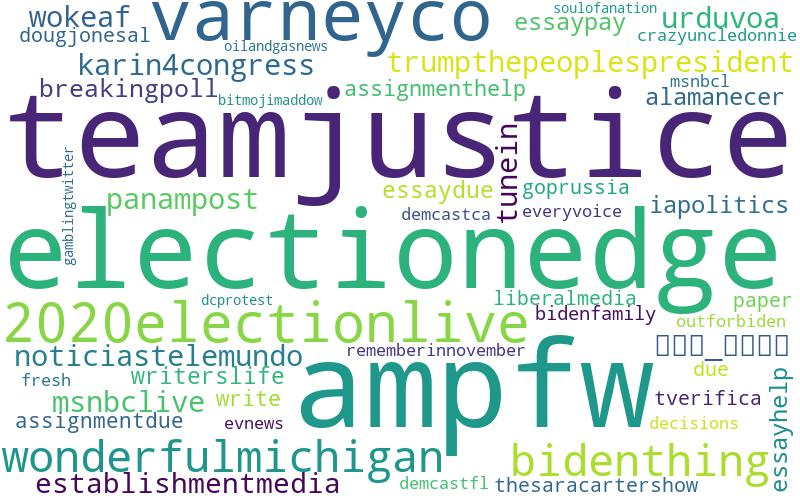


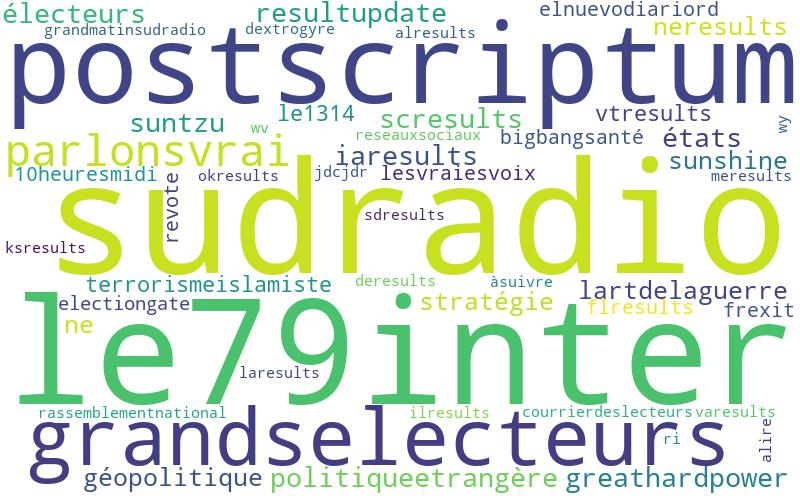


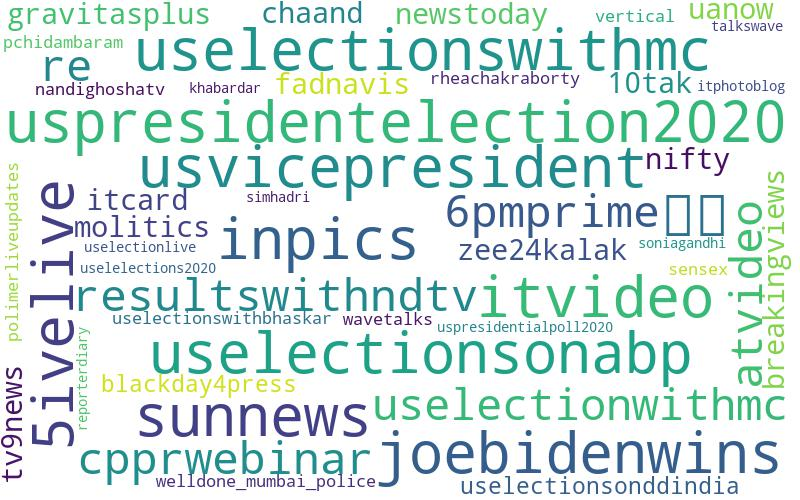


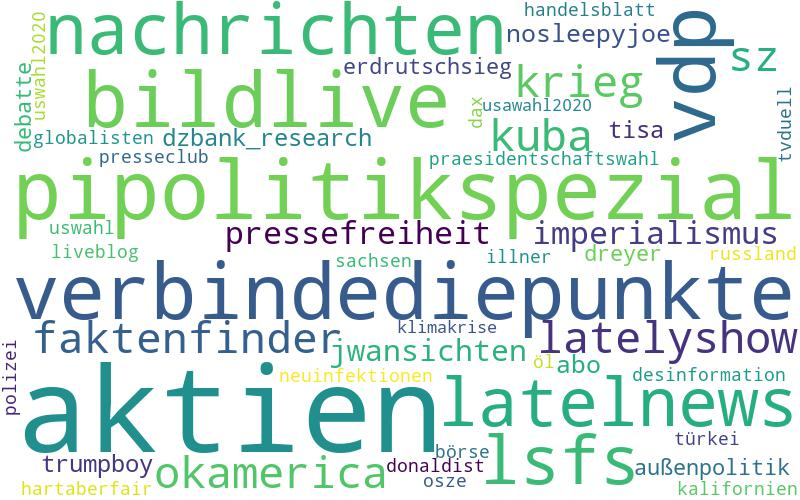


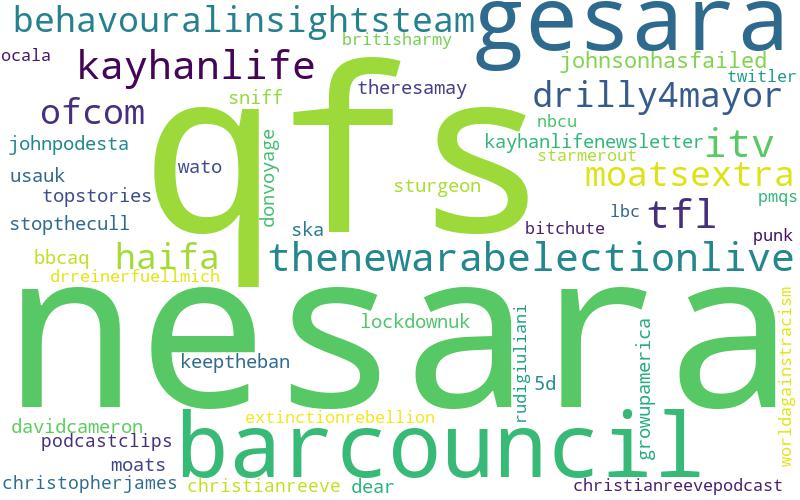


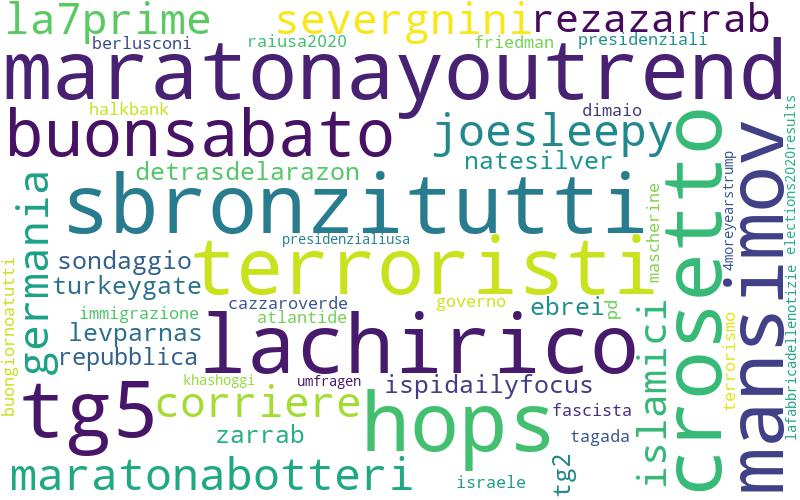


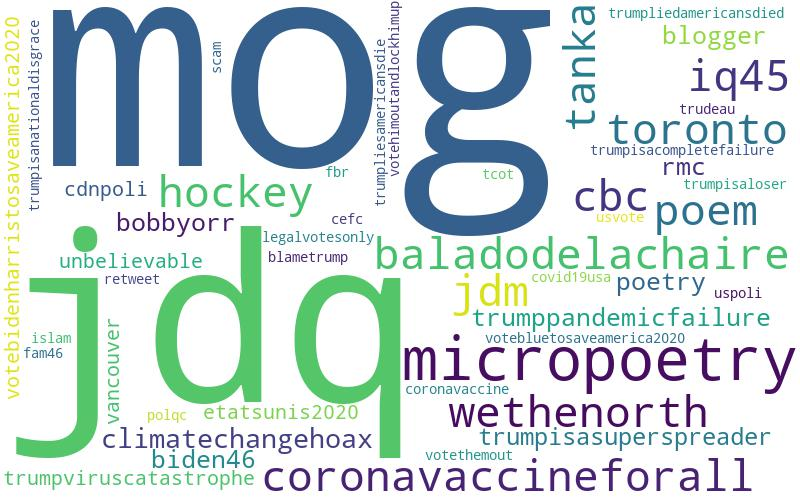


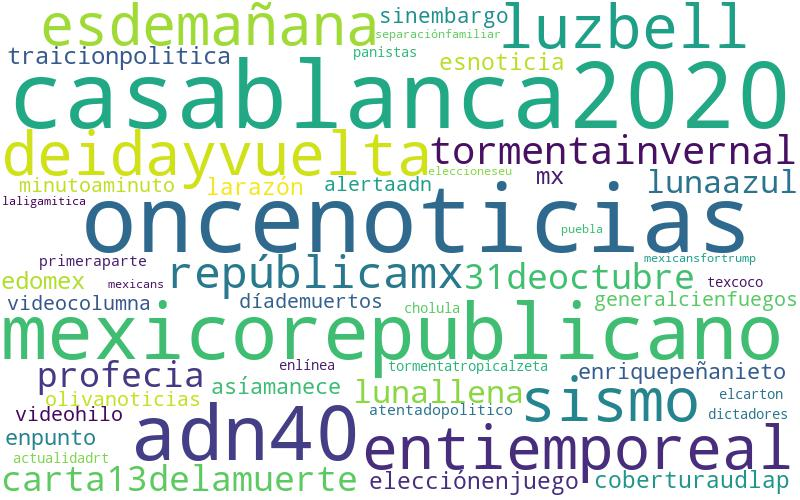


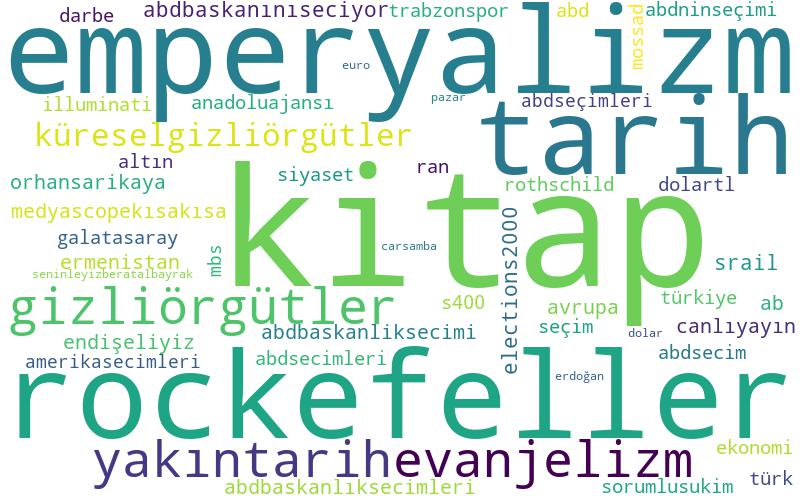


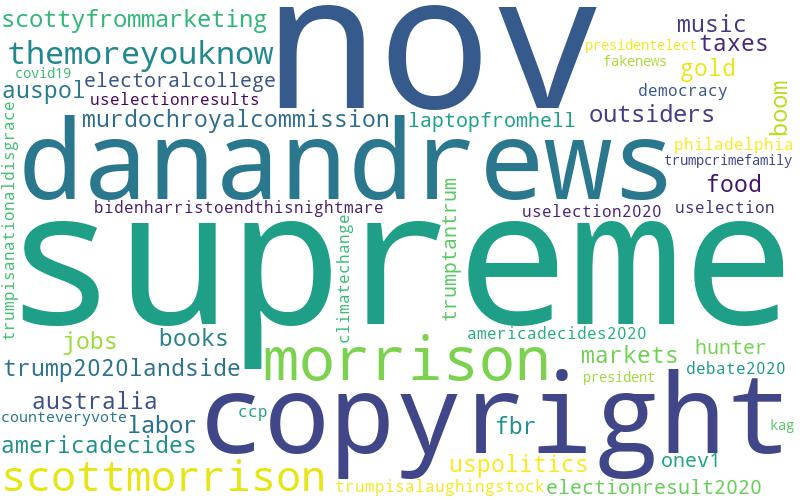


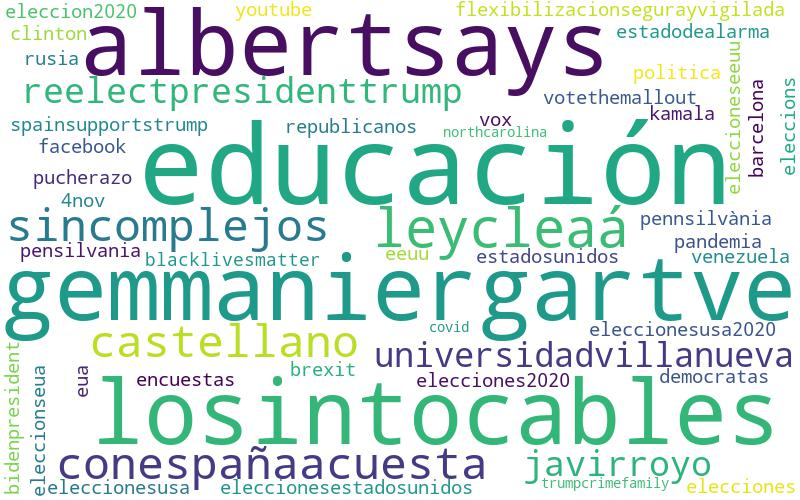


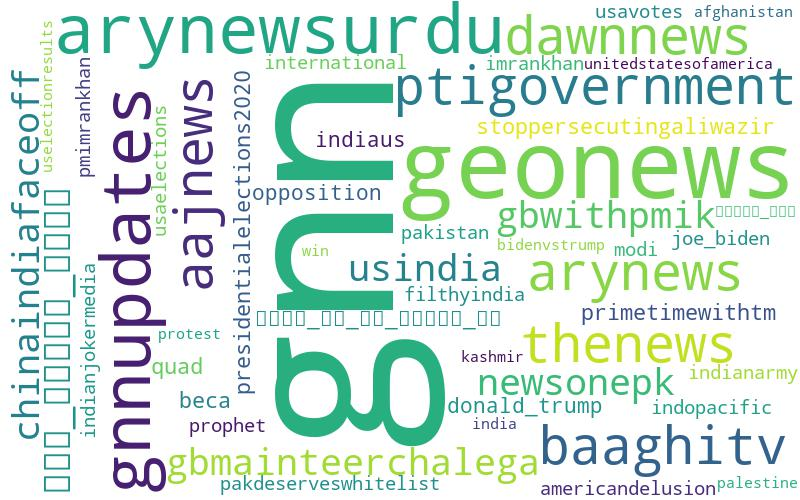


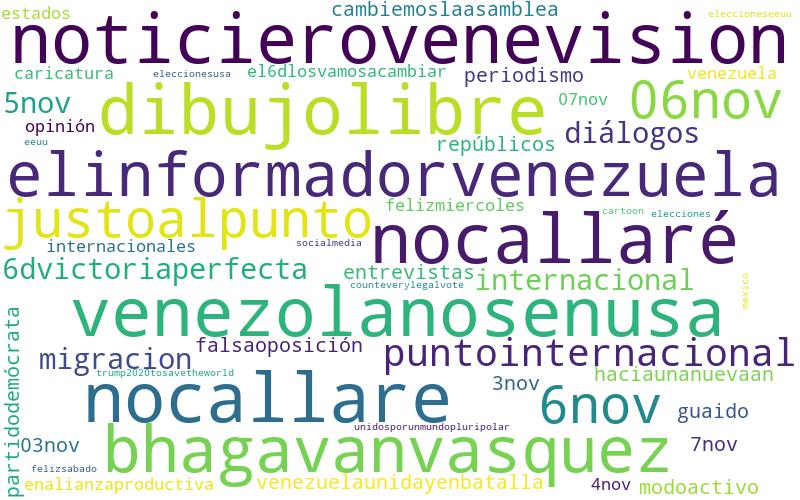


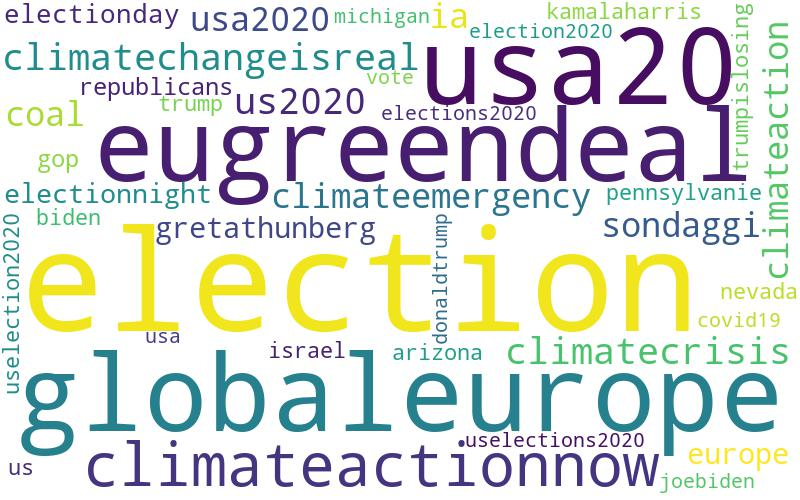


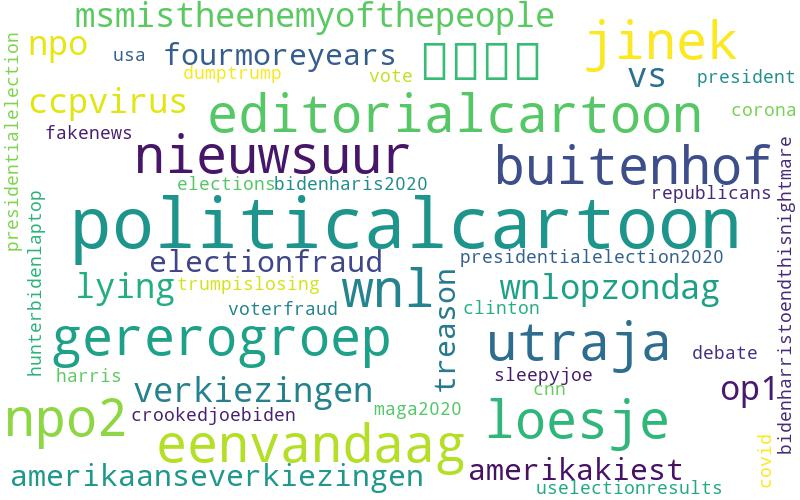


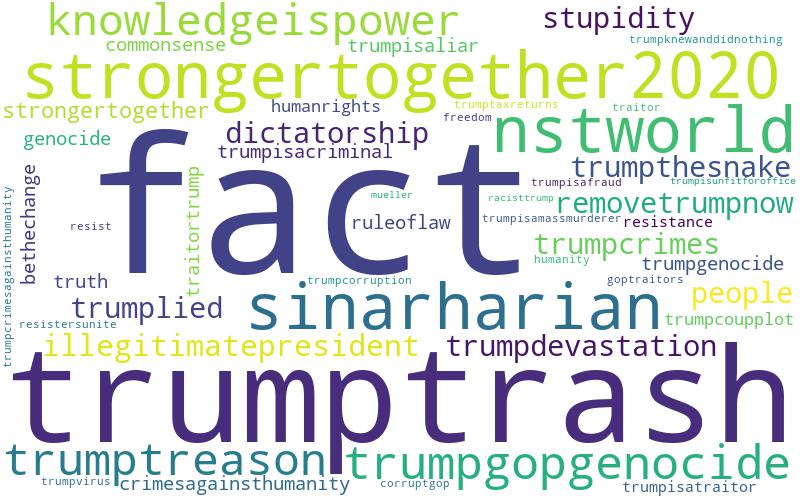


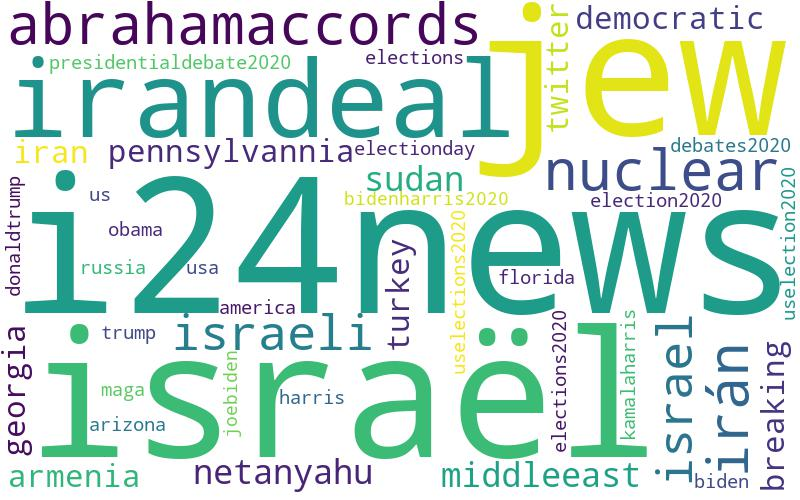


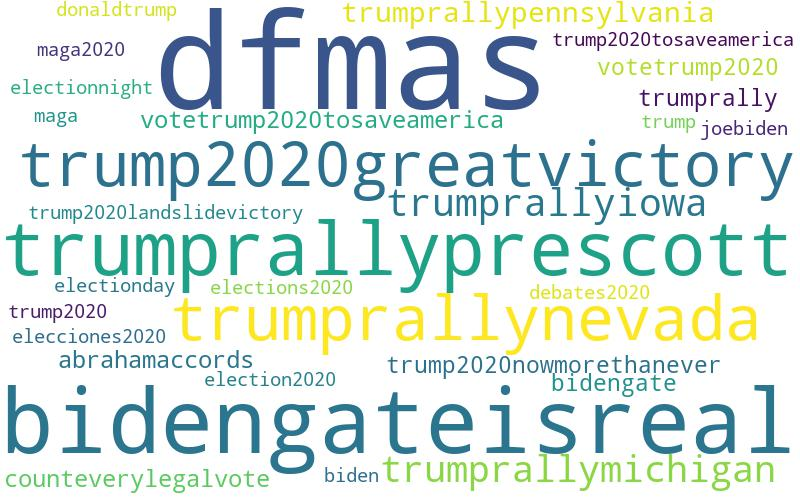


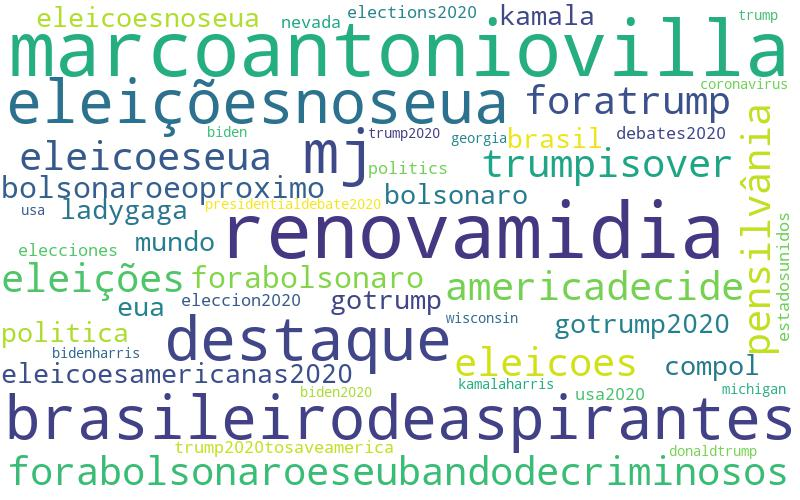


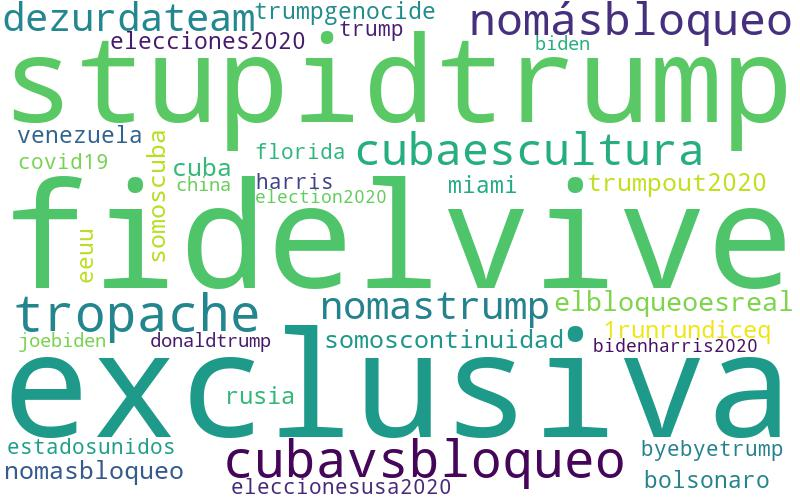

In [35]:
clean_onwership(all_df, "country")

# Word cloud hashtag by state

> See what's on eash states' mind


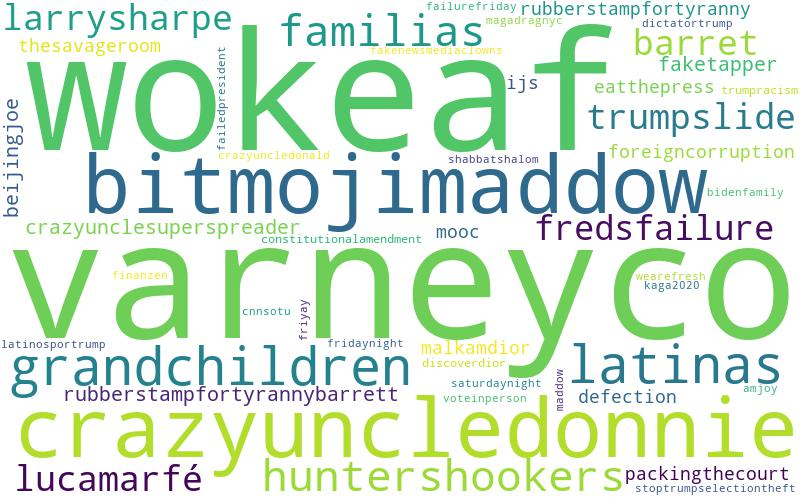


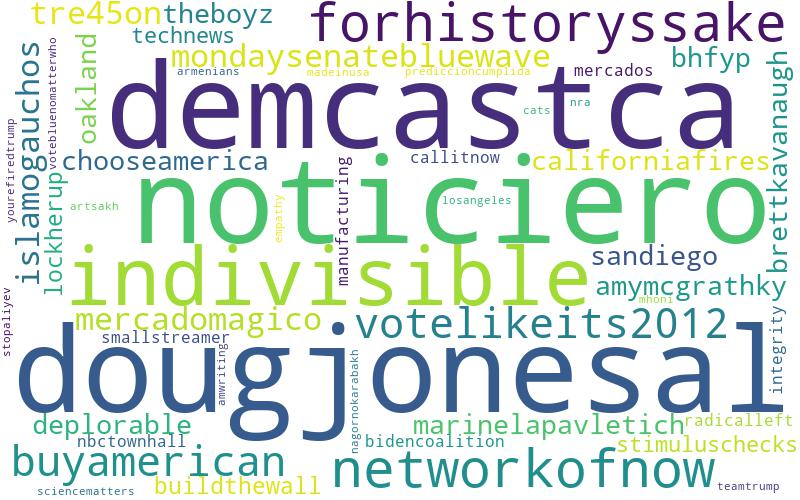


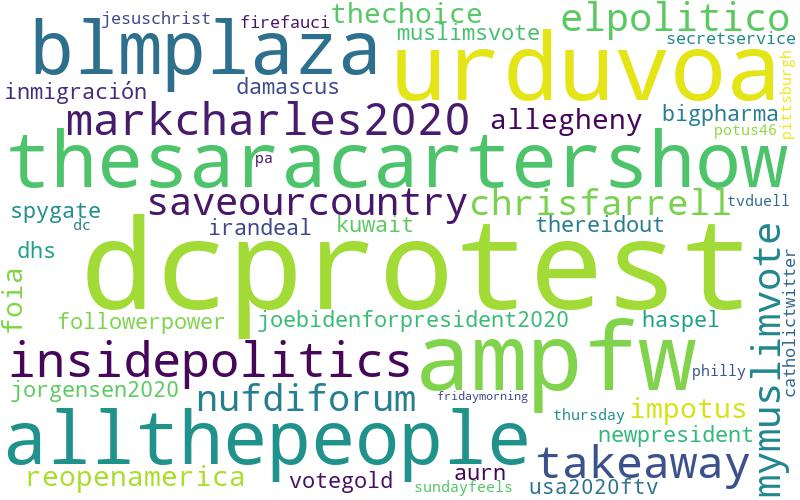


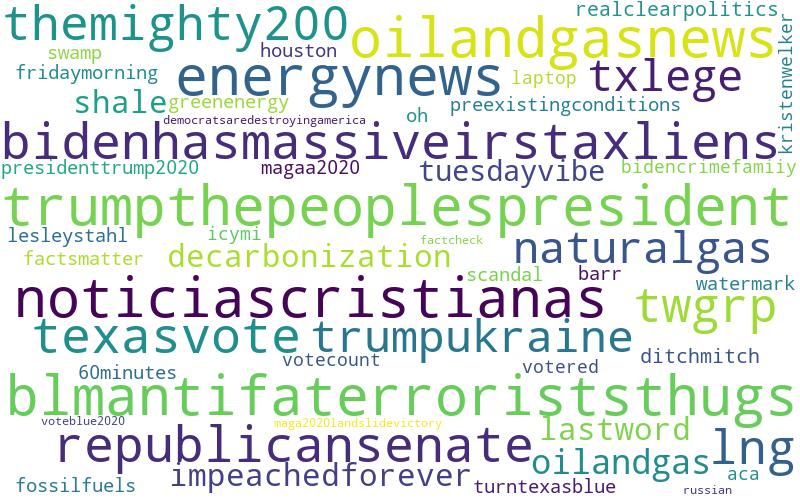


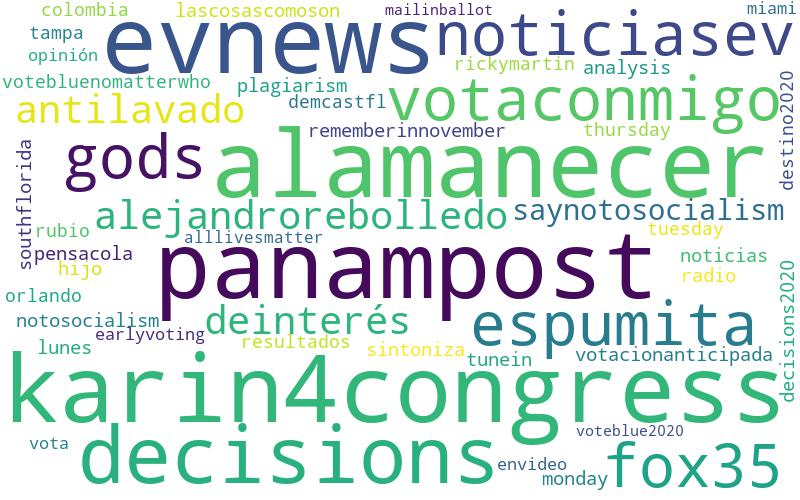


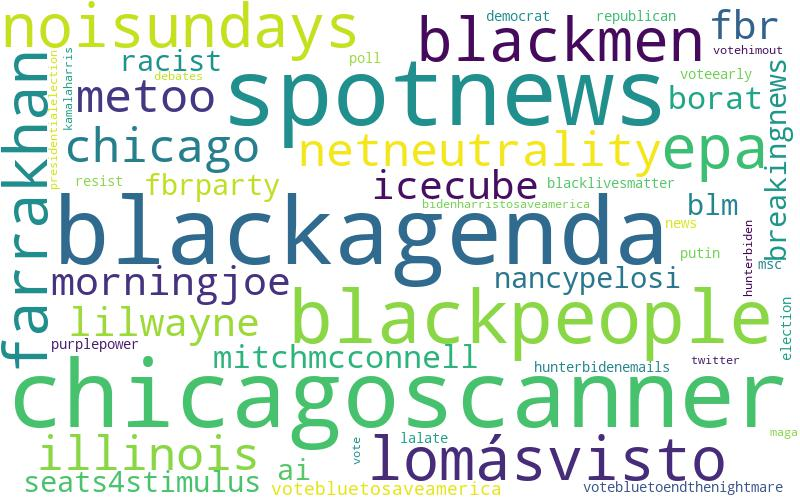


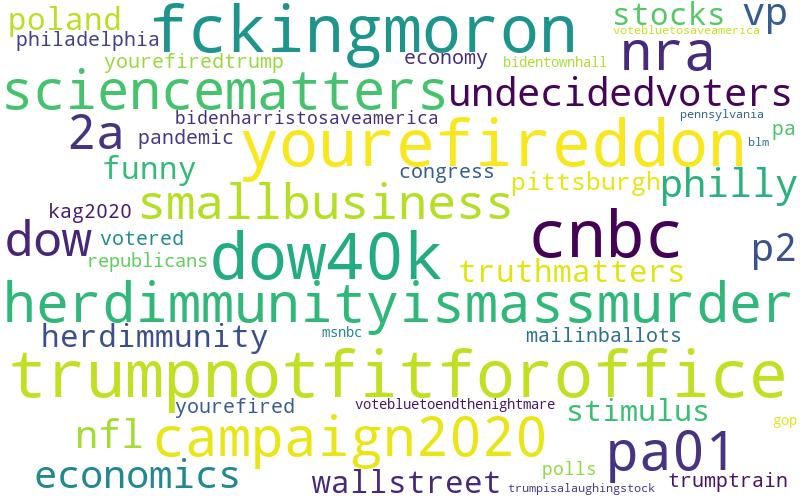


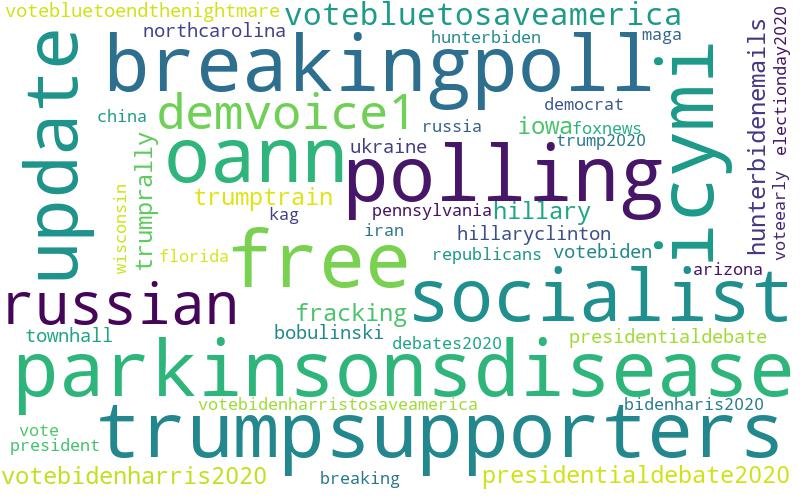


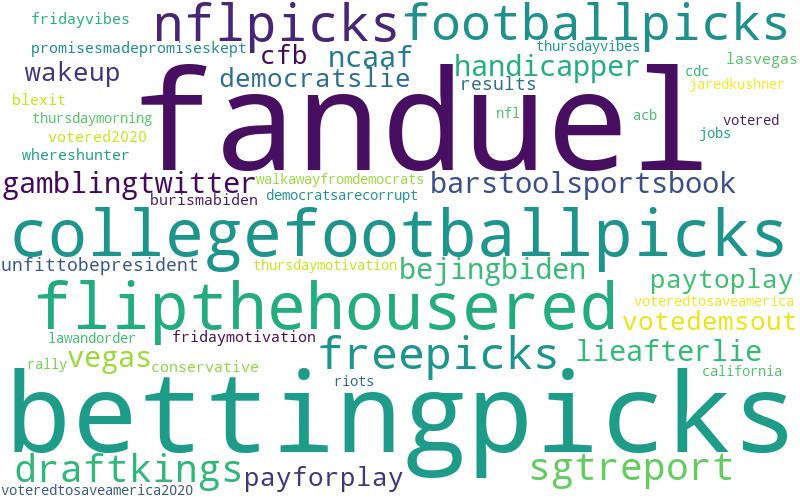


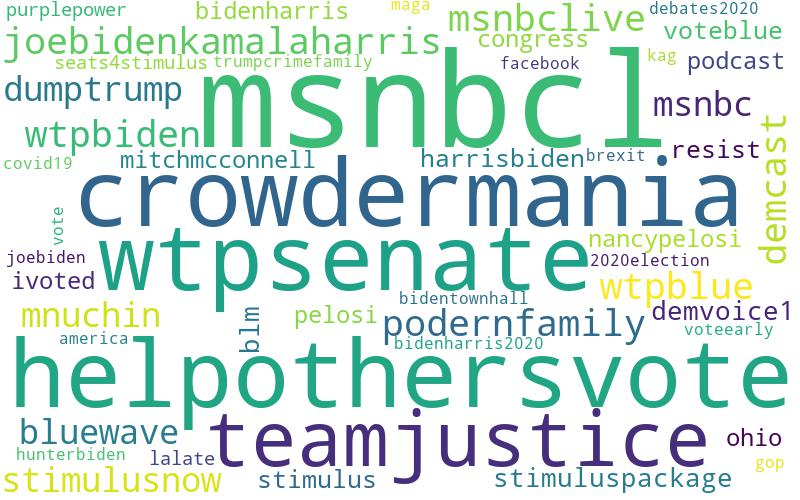


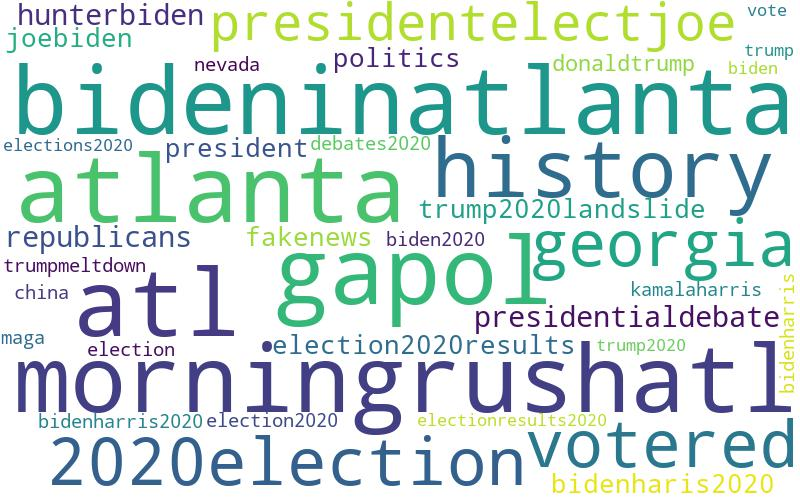


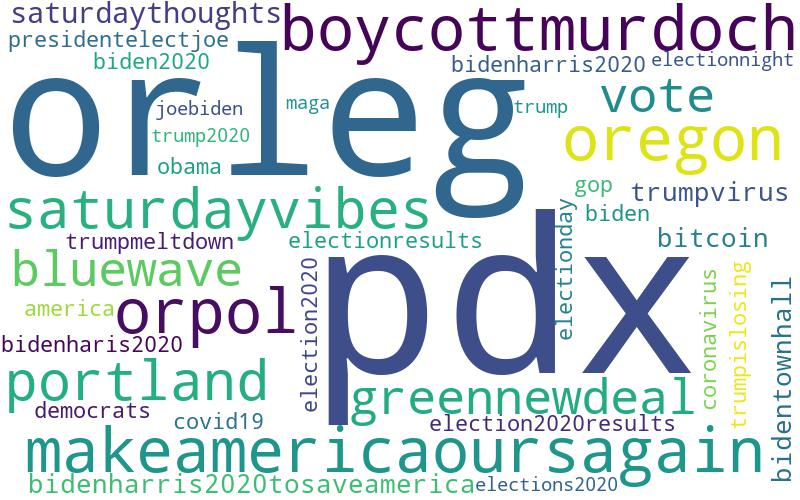


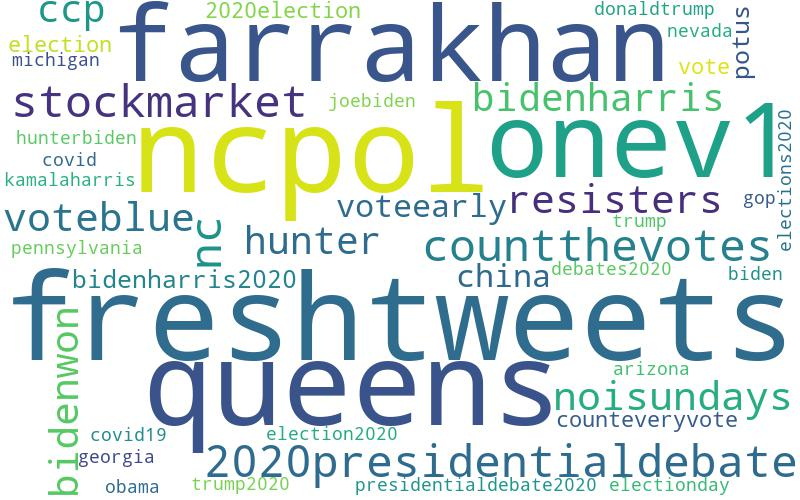


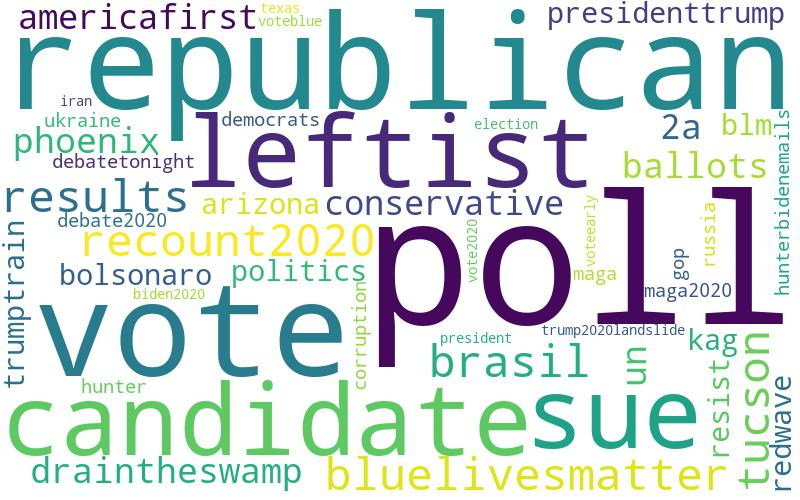


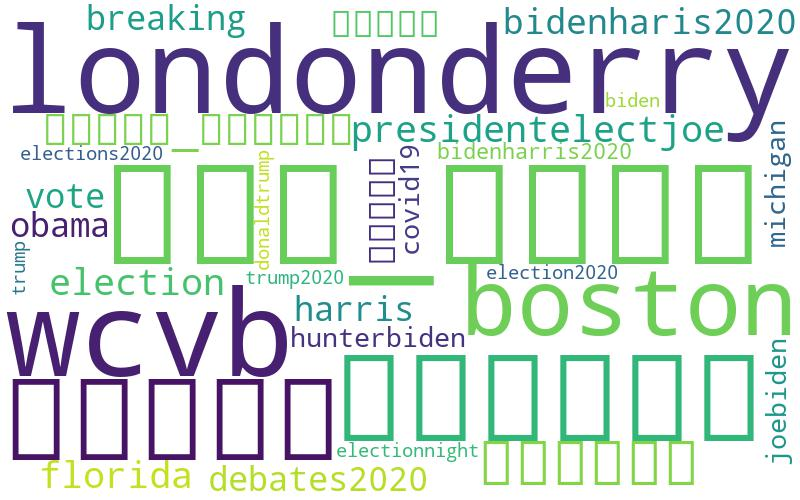


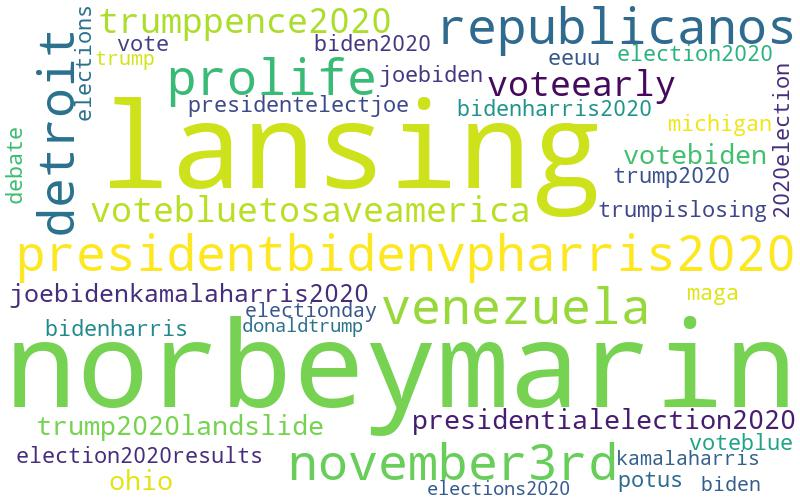


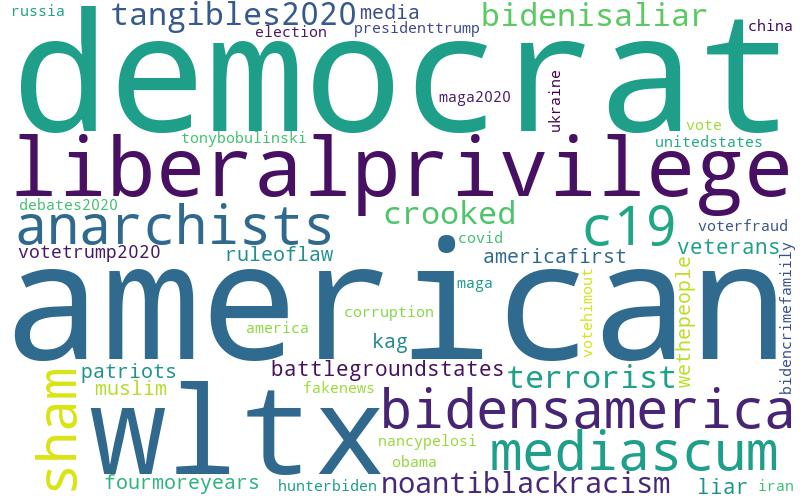


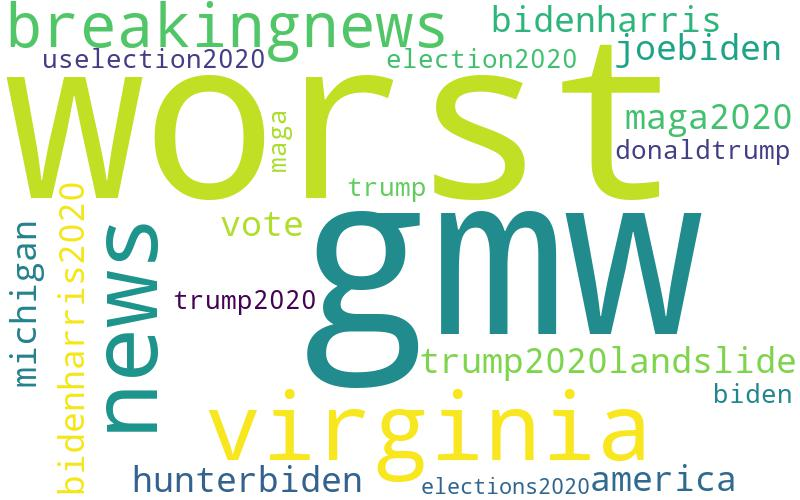


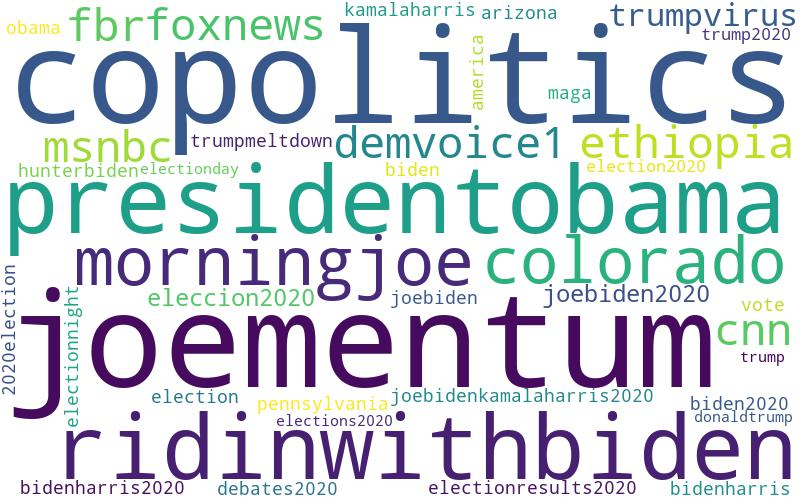


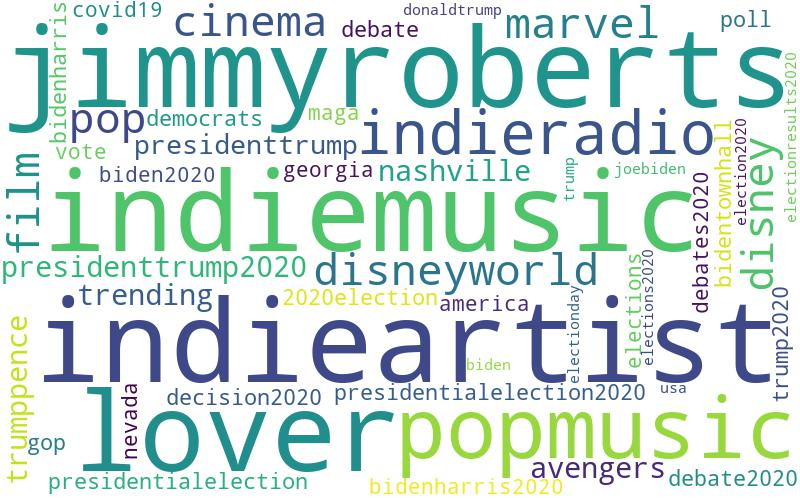

In [36]:
clean_onwership(all_df.query("country=='US'"), "state")